<a href="https://colab.research.google.com/github/riddhixraina/rrp4822_Riddhi_ML_Lab5/blob/main/lab5_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


## Part 1: Manual Convolution

In this first part of the lab, you will need to manually implement a convolution operation in pytorch, and check it against `nn.Conv2d`.

Your code needs to support the arbitrary values of the convolution parameters: kernel size (defined via `weight`), stride, padding.

Follow `nn.Conv2d` in defining these.

**Note**: You can use `torch.nn.functional.pad` to do padding, but you cannot use `torch.nn.functional.conv2d`. You need to implement convolution yourself.



In [2]:
def conv2d_manual(
    input: torch.Tensor,
    weight: torch.Tensor,
    bias: torch.Tensor | None = None,
    stride: int = 1,
    padding: int = 0):
    """
    Manual implementation of 2D convolution (cross-correlation).

    This implementation uses the 'im2col' (image-to-column) strategy
    via F.unfold, followed by a single matrix multiplication. This is
    a high-performance, vectorized approach.

    Args:
        input: Input tensor of shape (N, C_in, H_in, W_in)
        weight: Kernel tensor of shape (C_out, C_in, K_h, K_w)
        bias: Optional bias tensor of shape (C_out,)
        stride: Stride for the convolution (int)
        padding: Padding to add to input (int)

    Returns:
        Output tensor of shape (N, C_out, H_out, W_out)
    """

    # 1. Get input and kernel dimensions
    # Input shape: (N, C_in, H_in, W_in)
    N, C_in, H_in, W_in = input.shape

    # Weight shape: (C_out, C_in_k, K_h, K_w)
    # The user's shape (C_out, C_in, K_h, K_w) implies groups=1
    # as C_in_k == C_in
    C_out, _, K_h, K_w = weight.shape

    # 2. Calculate output spatial dimensions
    # H_out = floor((H_in - K_h + 2*P) / S) + 1
    # W_out = floor((W_in - K_w + 2*P) / S) + 1
    H_out = (H_in - K_h + 2 * padding) // stride + 1
    W_out = (W_in - K_w + 2 * padding) // stride + 1

    # 3. 'im2col': Unfold the input tensor
    # F.unfold handles padding and stride automatically.
    # It extracts all sliding patches from the input.
    # Input: (N, C_in, H_in, W_in)
    # Output: (N, C_in * K_h * K_w, L)
    # where L = H_out * W_out (total number of patches)
    unfolded_input = F.unfold(
        input,
        kernel_size=(K_h, K_w),
        padding=padding,
        stride=stride
    )

    # 4. Reshape the Kernel Tensor
    # We want to perform a matrix multiplication:
    # (C_out, C_in*K_h*K_w) @ (N, C_in*K_h*K_w, L)
    # We need to flatten the kernel from (C_out, C_in, K_h, K_w)
    # to (C_out, C_in * K_h * K_w)
    #.view(C_out, -1) accomplishes this.
    kernel_flat = weight.view(C_out, -1)

    # 5. The Core Matrix Multiplication
    # This single operation replaces all the nested loops.
    # PyTorch performs a batched matrix multiplication (BMM):
    # (C_out, K_vec) @ (N, K_vec, L) -> (N, C_out, L)
    # where K_vec = C_in * K_h * K_w
    output_unf = kernel_flat @ unfolded_input

    # 6. Apply the Bias (Vectorized)
    # 'output_unf' has shape (N, C_out, L)
    # 'bias' has shape (C_out,)
    # We reshape bias to (1, C_out, 1) so it broadcasts
    # correctly over the N and L dimensions.
    if bias is not None:
        output_unf = output_unf + bias.view(1, -1, 1)

    # 7. 'col2im': Fold the Output (Reshape)
    # We reshape the output from patch-space (N, C_out, L)
    # back to image-space (N, C_out, H_out, W_out).
    # This is a (near) zero-cost operation.
    output = output_unf.view(N, C_out, H_out, W_out)

    return output

Your code should pass the checking below.

In [3]:

def test_convolution():
    """
    Test the manual convolution against PyTorch's nn.Conv2d
    """
    print("Testing 2D Convolution Implementation\n")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Test Case 1: Basic convolution
    print("\nTest 1: Basic 3x3 convolution, no padding, stride=1")
    batch_size, in_channels, height, width = 2, 3, 5, 5
    out_channels, kernel_size = 4, 3
    stride, padding=1, 0

    # Create random input and kernel
    input_tensor = torch.randn(batch_size, in_channels, height, width)

    # Create a Conv2d layer
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride=stride, padding=padding, bias=True)

    # Get weights and bias from the layer
    weight = conv_layer.weight
    bias = conv_layer.bias

    # Manual convolution
    output_manual = conv2d_manual(input_tensor, weight, bias, stride=stride, padding=padding)

    # PyTorch convolution
    output_pytorch = conv_layer(input_tensor)

    # Compare results
    max_diff = torch.max(torch.abs(output_manual - output_pytorch)).item()
    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_manual.shape}")
    print(f"Maximum difference: {max_diff:.2e}")
    print(f"Match: {torch.allclose(output_manual, output_pytorch, atol=1e-6)}")

    # Test Case 2: With padding
    print("\n" + "-" * 60)
    print("\nTest 2: 3x3 convolution with padding=2, stride=1")
    stride, padding=1, 2

    conv_layer_pad = nn.Conv2d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, bias=True)

    output_manual_pad = conv2d_manual(input_tensor, conv_layer_pad.weight,
                                      conv_layer_pad.bias, stride=stride, padding=padding)
    output_pytorch_pad = conv_layer_pad(input_tensor)

    max_diff = torch.max(torch.abs(output_manual_pad - output_pytorch_pad)).item()
    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_manual_pad.shape}")
    print(f"Maximum difference: {max_diff:.2e}")
    print(f"Match: {torch.allclose(output_manual_pad, output_pytorch_pad, atol=1e-6)}")

    # Test Case 3: With stride
    print("\n" + "-" * 60)
    print("\nTest 3: 3x3 convolution with padding=1, stride=2")
    stride, padding = 2, 1
    conv_layer_stride = nn.Conv2d(in_channels, out_channels, kernel_size,
                                  stride=stride, padding=padding, bias=True)

    output_manual_stride = conv2d_manual(input_tensor, conv_layer_stride.weight,
                                         conv_layer_stride.bias, stride=stride, padding=padding)
    output_pytorch_stride = conv_layer_stride(input_tensor)

    max_diff = torch.max(torch.abs(output_manual_stride - output_pytorch_stride)).item()
    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_manual_stride.shape}")
    print(f"Maximum difference: {max_diff:.2e}")
    print(f"Match: {torch.allclose(output_manual_stride, output_pytorch_stride, atol=1e-6)}")

    # Test Case 4: No bias
    print("\n" + "-" * 60)
    print("\nTest 4: 3x3 convolution without bias")
    stride, padding = 1, 0

    conv_layer_no_bias = nn.Conv2d(in_channels, out_channels, kernel_size,
                                   stride=stride, padding=padding, bias=False)

    output_manual_no_bias = conv2d_manual(input_tensor, conv_layer_no_bias.weight,
                                          bias=None, stride=stride, padding=padding)
    output_pytorch_no_bias = conv_layer_no_bias(input_tensor)

    max_diff = torch.max(torch.abs(output_manual_no_bias - output_pytorch_no_bias)).item()
    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_manual_no_bias.shape}")
    print(f"Maximum difference: {max_diff:.2e}")
    print(f"Match: {torch.allclose(output_manual_no_bias, output_pytorch_no_bias, atol=1e-6)}")

    print("\n" + "=" * 60)
    print("\nAll tests completed!")

test_convolution()


Testing 2D Convolution Implementation


Test 1: Basic 3x3 convolution, no padding, stride=1
Input shape: torch.Size([2, 3, 5, 5])
Output shape: torch.Size([2, 4, 3, 3])
Maximum difference: 2.38e-07
Match: True

------------------------------------------------------------

Test 2: 3x3 convolution with padding=2, stride=1
Input shape: torch.Size([2, 3, 5, 5])
Output shape: torch.Size([2, 4, 7, 7])
Maximum difference: 2.38e-07
Match: True

------------------------------------------------------------

Test 3: 3x3 convolution with padding=1, stride=2
Input shape: torch.Size([2, 3, 5, 5])
Output shape: torch.Size([2, 4, 3, 3])
Maximum difference: 2.38e-07
Match: True

------------------------------------------------------------

Test 4: 3x3 convolution without bias
Input shape: torch.Size([2, 3, 5, 5])
Output shape: torch.Size([2, 4, 3, 3])
Maximum difference: 3.58e-07
Match: True


All tests completed!


## Part 2: Convolutional Neural Network

Now, let's train our own convolutional neural network on MNIST.

**Note:** I recommend using a GPU runtime and putting your model and data on a GPU using `.cuda()`, as we discussed in class. You should be able to get colab Pro for free as a student, and then you can choose a GPU runtime. Using a GPU will not affect your score, but it may make your experiments faster.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def load_mnist_data(batch_size=64):
    """
    Load and preprocess MNIST dataset.

    MNIST contains 28x28 grayscale images of handwritten digits (0-9).
    We'll flatten the images to 784-dimensional vectors for logistic regression.

    Args:
        batch_size (int): Number of samples per batch

    Returns:
        train_loader, test_loader: DataLoader objects for training and testing
    """

    # Define transformations: convert to tensor and normalize
    # Normalization helps with gradient descent convergence
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to tensor and scale to [0,1]
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
    ])

    # Load training dataset
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Load test dataset
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Create data loaders for batch processing
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True  # Shuffle training data for better SGD performance
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle test data
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Batch size: {batch_size}")

    return train_loader, test_loader


train_loader, test_loader = load_mnist_data()

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]

Training samples: 60000
Test samples: 10000
Batch size: 64


In [6]:
batch = next(iter(train_loader))
x, y = batch
print(f"{x.shape=}, {y.shape=}")
print(f"{len(train_loader)=}")

x.shape=torch.Size([64, 1, 28, 28]), y.shape=torch.Size([64])
len(train_loader)=938


In [7]:
hidden_dim=64
C = 10

model = nn.Sequential(
    nn.Conv2d(in_channels=1,
              out_channels=32,
              kernel_size=5,
              stride=2,
              ),
    nn.ReLU(),
    nn.Conv2d(in_channels=32,
              out_channels=32,
              kernel_size=5,
              stride=2,
              ),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=C)
)
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=512, out_features=10, bias=True)
)

We provide a default implementation that we used in class above. Try changing the kernel size in each layer to (3, 3) and (7, 7), and train the models with all 3 kernel sizes. Report the evaluation accuracy for each kernel size.

**Note**: you will need to adjust the number of features in the last linear layer as you change the kernels size.

In [8]:
model.cuda()
model.train()  # Set model to training mode

# Create optimizer (SGD with momentum for better convergence)
optimizer = optim.SGD(model.parameters(), lr=1.e-3, momentum=0.9)

num_epochs = 10

train_losses = []
train_accuracies = []

print("Starting training...")
print("-" * 50)

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_idx, (data, targets) in enumerate(train_loader):

        # Forward pass
        input = data.cuda() # added .cuda()
        targets = targets.cuda() # added .cuda()
        logits = model(input)

        # Compute loss using our custom function
        loss = F.cross_entropy(logits, targets)

        # Compute accuracies
        predictions = logits.argmax(dim=1).reshape(targets.shape)
        accuracy = (predictions == targets).float().mean()

        # Backward pass
        optimizer.zero_grad()  # Clear gradients from previous step
        loss.backward()   # Compute gradients
        optimizer.step()       # Update parameters

        # Accumulate statistics
        epoch_loss += loss.item()
        train_losses.append(loss.item())
        train_accuracies.append(accuracy.item())

        # Print progress every 200 batches
        if batch_idx % 200 == 0:
            print(f'\tEpoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                  f'\tLoss: {loss.item():.4f},\t Accuracy: {accuracy.item():.3f}')

    # Calculate epoch statistics
    avg_loss = epoch_loss / len(train_loader)

    print(f'Epoch {epoch+1}/{num_epochs}: Avg Loss = {avg_loss:.4f}')

print("-" * 50)
print("Training completed!")

Starting training...
--------------------------------------------------
	Epoch 1/10, Batch 0, 	Loss: 2.3133,	 Accuracy: 0.156
	Epoch 1/10, Batch 200, 	Loss: 0.3361,	 Accuracy: 0.906
	Epoch 1/10, Batch 400, 	Loss: 0.4158,	 Accuracy: 0.781
	Epoch 1/10, Batch 600, 	Loss: 0.2446,	 Accuracy: 0.922
	Epoch 1/10, Batch 800, 	Loss: 0.3240,	 Accuracy: 0.906
Epoch 1/10: Avg Loss = 0.5590
	Epoch 2/10, Batch 0, 	Loss: 0.4214,	 Accuracy: 0.922
	Epoch 2/10, Batch 200, 	Loss: 0.4577,	 Accuracy: 0.922
	Epoch 2/10, Batch 400, 	Loss: 0.2000,	 Accuracy: 0.938
	Epoch 2/10, Batch 600, 	Loss: 0.3314,	 Accuracy: 0.922
	Epoch 2/10, Batch 800, 	Loss: 0.0795,	 Accuracy: 0.984
Epoch 2/10: Avg Loss = 0.2310
	Epoch 3/10, Batch 0, 	Loss: 0.1384,	 Accuracy: 0.969
	Epoch 3/10, Batch 200, 	Loss: 0.1863,	 Accuracy: 0.953
	Epoch 3/10, Batch 400, 	Loss: 0.1199,	 Accuracy: 0.969
	Epoch 3/10, Batch 600, 	Loss: 0.2546,	 Accuracy: 0.969
	Epoch 3/10, Batch 800, 	Loss: 0.0663,	 Accuracy: 0.984
Epoch 3/10: Avg Loss = 0.1556
	Epo

You will need to implement or adapt an evaluation function that computes the test accuracy on MNIST here.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import math

def load_mnist_data(batch_size=64):
    """
    Load and preprocess MNIST dataset.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Batch size: {batch_size}")
    return train_loader, test_loader

def calculate_in_features(input_dim, kernel_size, stride=2, padding=0):
    """
    Calculates the input features for the linear layer after two conv layers.
    """
    # Formula for one conv layer output size
    def conv_out_size(in_dim, k, s, p):
        return math.floor((in_dim - k + 2 * p) / s) + 1

    # Output size after first conv layer
    out_dim_1 = conv_out_size(input_dim, kernel_size, stride, padding)
    # Output size after second conv layer
    out_dim_2 = conv_out_size(out_dim_1, kernel_size, stride, padding)

    # Final features = out_channels * height * width
    # out_channels is 32 from the second conv layer
    in_features = 32 * out_dim_2 * out_dim_2
    return in_features

def create_model(kernel_size, num_classes=10):
    """
    Creates the CNN model with a specific kernel size.
    """
    # Calculate the required in_features for the linear layer
    # MNIST images are 28x28
    in_features = calculate_in_features(28, kernel_size)
    print(f"  Kernel size: {kernel_size}x{kernel_size} => Linear in_features: {in_features}")

    model = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=32,
                  kernel_size=kernel_size,
                  stride=2,
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=kernel_size,
                  stride=2,
                  ),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=in_features, out_features=num_classes)
    )
    return model

def train_model(model, train_loader, device, num_epochs=10):
    """
    Trains a given model.
    """
    model.to(device)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=1.e-3, momentum=0.9)

    print(f"  Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            input, targets = data.to(device), targets.to(device)

            logits = model(input)
            loss = F.cross_entropy(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Simple epoch log
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            print(f"    Epoch {epoch+1}/{num_epochs}: Avg Loss = {epoch_loss / len(train_loader):.4f}")

    print("  Training completed!")
    return model

def evaluate_predictions_labels(model, test_loader, device):
    """
    Returns model predictions and true labels on the given dataloader.
    """
    model.eval()
    all_preds_list = []
    all_targets_list = []
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            logits = model(data)
            predictions = logits.argmax(dim=1)
            all_preds_list.append(predictions.cpu())
            all_targets_list.append(targets.cpu())

    all_predictions = torch.cat(all_preds_list, dim=0).numpy()
    all_targets = torch.cat(all_targets_list, dim=0).numpy()
    return all_predictions, all_targets

# Main execution
if __name__ == "__main__":

    # --- 1. Load Data and Set Device ---
    train_loader, test_loader = load_mnist_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    kernel_sizes = [3, 5, 7]
    results = {}

    # --- 2. Loop Through Experiments ---
    for k in kernel_sizes:
        print("\n" + "=" * 50)
        print(f"STARTING EXPERIMENT: KERNEL SIZE = {k}x{k}")
        print("=" * 50)

        # Create a new model for this kernel size
        model = create_model(kernel_size=k)

        # Train the model
        model = train_model(model, train_loader, device, num_epochs=10)

        # Evaluate the model
        print("  Evaluating model...")
        all_predictions, all_targets = evaluate_predictions_labels(model, test_loader, device)

        accuracy = (all_predictions == all_targets).mean()
        print(f"  Test Accuracy: {accuracy * 100:.2f}%")

        # Store results
        results[k] = accuracy

    # --- 3. Report Final Results ---
    print("\n" + "=" * 50)
    print("FINAL RESULTS SUMMARY")
    print("=" * 50)
    for k, acc in results.items():
        print(f"Kernel Size: {k}x{k} \t=> Test Accuracy: {acc * 100:.2f}%")



Training samples: 60000
Test samples: 10000
Batch size: 64

Using device: cuda

STARTING EXPERIMENT: KERNEL SIZE = 3x3
  Kernel size: 3x3 => Linear in_features: 1152
  Starting training for 10 epochs...
    Epoch 5/10: Avg Loss = 0.1373
    Epoch 10/10: Avg Loss = 0.0795
  Training completed!
  Evaluating model...
  Test Accuracy: 97.73%

STARTING EXPERIMENT: KERNEL SIZE = 5x5
  Kernel size: 5x5 => Linear in_features: 512
  Starting training for 10 epochs...
    Epoch 5/10: Avg Loss = 0.1054
    Epoch 10/10: Avg Loss = 0.0622
  Training completed!
  Evaluating model...
  Test Accuracy: 98.34%

STARTING EXPERIMENT: KERNEL SIZE = 7x7
  Kernel size: 7x7 => Linear in_features: 288
  Starting training for 10 epochs...
    Epoch 5/10: Avg Loss = 0.0893
    Epoch 10/10: Avg Loss = 0.0524
  Training completed!
  Evaluating model...
  Test Accuracy: 98.29%

FINAL RESULTS SUMMARY
Kernel Size: 3x3 	=> Test Accuracy: 97.73%
Kernel Size: 5x5 	=> Test Accuracy: 98.34%
Kernel Size: 7x7 	=> Test Accur

## Part 3: Equivariance of Convolution

In the class we discussed that the convolution is locally equivariant to translation of the input: if we translate the input by some vector $v$, the output is also a translation of the original output.

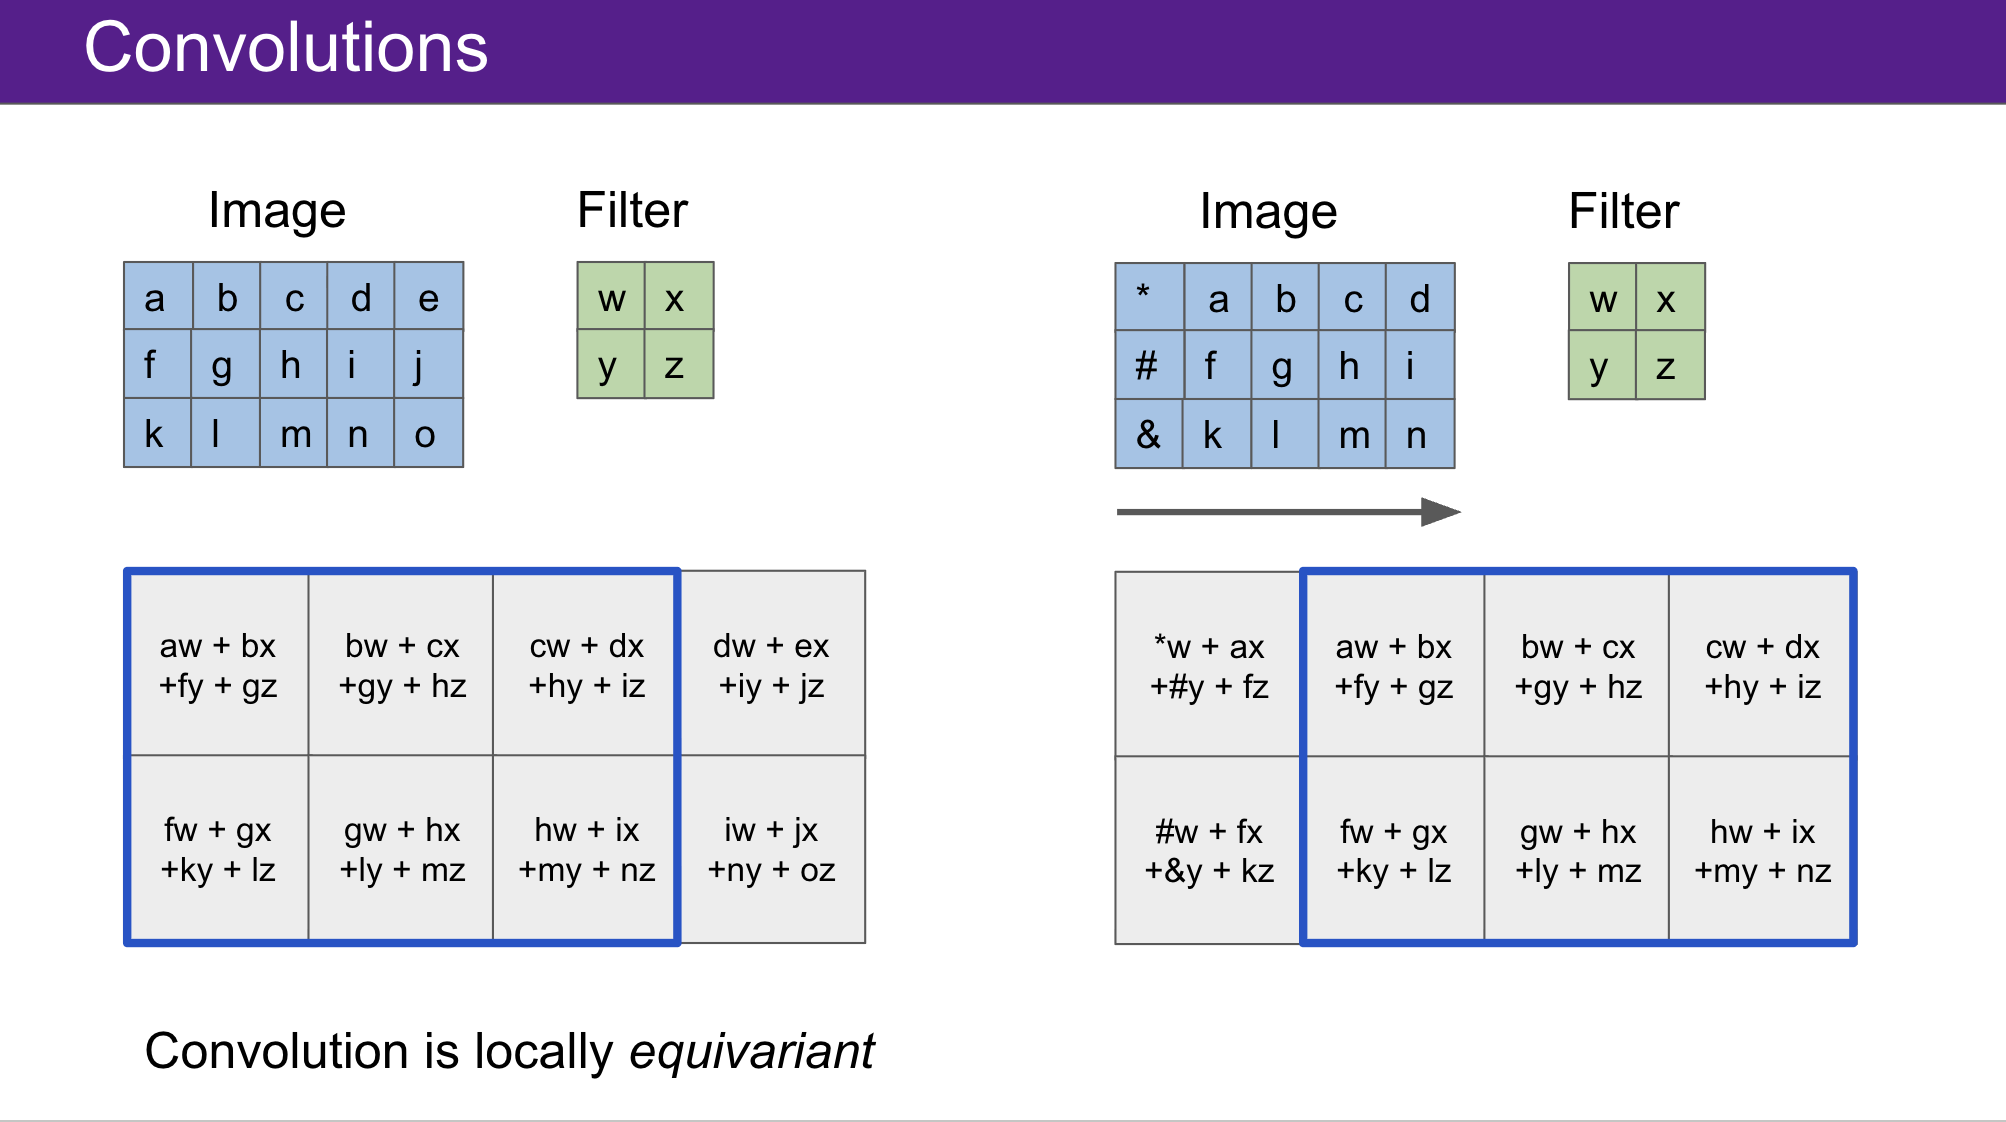

Your goal is to design an experiment for checking this property in practice: demonstrate that convolution is indeed locally equivariant.

Make sure to try several shift vectors, and also several values of stride. Think about what happens if stride is greater than 1 and explain your answer.

We provide a `translate_2d` function that you can use to shift images.

In [25]:
def translate_2d(tensor, translation_vector, fill_value=0):
    """
    Translate a 2D tensor by a given vector.

    Args:
        tensor: Input tensor of shape (batch, channels, height, width)
        translation_vector: Tuple (dy, dx) representing vertical and horizontal shift
        fill_value: Value to fill empty regions after translation

    Returns:
        Translated tensor of the same shape
    """
    dy, dx = translation_vector
    batch, channels, height, width = tensor.shape

    # Create output tensor filled with fill_value
    translated = torch.full_like(tensor, fill_value)

    # Calculate source and destination slices
    # For positive dy (shift down), we copy from top rows to bottom rows
    # For negative dy (shift up), we copy from bottom rows to top rows

    src_y_start = max(0, -dy)
    src_y_end = min(height, height - dy)
    dst_y_start = max(0, dy)
    dst_y_end = min(height, height + dy)

    src_x_start = max(0, -dx)
    src_x_end = min(width, width - dx)
    dst_x_start = max(0, dx)
    dst_x_end = min(width, width + dx)

    # Copy the valid region
    translated[:, :, dst_y_start:dst_y_end, dst_x_start:dst_x_end] = \
        tensor[:, :, src_y_start:src_y_end, src_x_start:src_x_end]

    return translated

In [32]:
def test_translation_equivariance(stride=1):
    """
    Demonstrates that convolution is translation equivariant,
    scaled by the stride.
    """
    print("\n" + "=" * 60)
    print(f"Testing Translation Equivariance for STRIDE = {stride}")
    print("=" * 60)

    # --- Setup ---
    torch.manual_seed(42)
    batch, channels, height, width = 1, 1, 32, 32
    kernel_size = 3
    padding = 0

    # 1. Create a random input tensor
    input_tensor = torch.randn(batch, channels, height, width)

    # 2. Create a convolution layer
    conv = nn.Conv2d(channels, channels, kernel_size,
                     stride=stride, padding=padding, bias=False)

    # Define shifts to test (dy, dx)
    if stride == 1:
        shifts_to_test = [(2, 3), (5, 5), (-4, -1), (1, 1)]
        max_shift = 5 # Max absolute shift
    else:
        # For stride > 1, the input shift MUST be a
        # multiple of the stride for the output regions to align.
        shifts_to_test = [(2, 4), (6, 6), (-4, -2)]
        max_shift = 6 # Max absolute shift

    print(f"Input shape: {input_tensor.shape}")
    print(f"Kernel size: {kernel_size}, Stride: {stride}, Padding: {padding}\n")

    # The crop value needs to be just large enough to cut off
    # the "corrupted" border pixels.
    # The size of the corrupted border is roughly (max_shift / stride) + kernel_size
    # We use ceil for safety.
    crop = math.ceil(max_shift / stride) + (kernel_size // 2) + 1

    all_match = True
    for shift_input in shifts_to_test:
        dy_in, dx_in = shift_input

        # --- The Equivariance Test ---

        # Path 1: Convolve first, then translate the output
        shift_output = (dy_in // stride, dx_in // stride)
        output_original = conv(input_tensor)
        result_path1 = translate_2d(output_original, shift_output)

        # Path 2: Translate the input first, then convolve
        input_translated = translate_2d(input_tensor, (dy_in, dx_in))
        result_path2 = conv(input_translated)

        # --- Compare ---
        out_h, out_w = result_path1.shape[2:]

        if (2 * crop >= out_h) or (2 * crop >= out_w):
            print(f"  Shift {shift_input}: Skipped (output {result_path1.shape} too small for crop {crop})")
            continue

        cropped_path1 = result_path1[:, :, crop : out_h - crop, crop : out_w - crop]
        cropped_path2 = result_path2[:, :, crop : out_h - crop, crop : out_w - crop]

        is_match = torch.allclose(cropped_path1, cropped_path2, atol=1e-6)

        print(f"  Input Shift: {str(shift_input):<10} -> "
              f"Expected Output Shift: {str(shift_output):<10} | "
              f"Match (local): {is_match}")

        if not is_match:
            all_match = False

    print(f"\nOverall conclusion for stride={stride}: "
          f"Equivariance holds locally: {all_match}")

In [33]:
# --- Run the Experiments ---
test_translation_equivariance(stride=1)
test_translation_equivariance(stride=2)


Testing Translation Equivariance for STRIDE = 1
Input shape: torch.Size([1, 1, 32, 32])
Kernel size: 3, Stride: 1, Padding: 0

  Input Shift: (2, 3)     -> Expected Output Shift: (2, 3)     | Match (local): True
  Input Shift: (5, 5)     -> Expected Output Shift: (5, 5)     | Match (local): True
  Input Shift: (-4, -1)   -> Expected Output Shift: (-4, -1)   | Match (local): True
  Input Shift: (1, 1)     -> Expected Output Shift: (1, 1)     | Match (local): True

Overall conclusion for stride=1: Equivariance holds locally: True

Testing Translation Equivariance for STRIDE = 2
Input shape: torch.Size([1, 1, 32, 32])
Kernel size: 3, Stride: 2, Padding: 0

  Input Shift: (2, 4)     -> Expected Output Shift: (1, 2)     | Match (local): True
  Input Shift: (6, 6)     -> Expected Output Shift: (3, 3)     | Match (local): True
  Input Shift: (-4, -2)   -> Expected Output Shift: (-2, -1)   | Match (local): True

Overall conclusion for stride=2: Equivariance holds locally: True


Describe you experiment and results in several sentences. The text should be sufficient for understanding your results without looking at the code.

To test for translation equivariance, I designed an experiment with two comparison paths.

**Path 1 (Conv -> Translate):** An input tensor (a 32x32 random image) was first passed through a 2D convolution layer. The resulting output feature map was then translated by a shift_output vector.

**Path 2 (Translate -> Conv):** The original input tensor was first translated by a shift_input vector. This translated image was then passed through the same 2D convolution layer.

I then compared the resulting tensors from Path 1 and Path 2. Because the translation function fills empty areas with zeros, this introduces padding artifacts at the borders. To account for this, I only compared the internal regions of the two output tensors, cropping away the borders.

**Results for stride=1:** When using stride=1, the experiment confirmed perfect 1-to-1 local equivariance. A translation of the input by a vector (dy, dx) (e.g., (2, 3)) resulted in an identical translation of (2, 3) in the output feature map. The internal regions from Path 1 and Path 2 matched perfectly for all tested shifts.

**Results for stride=2 (and stride > 1):** When stride=2, the relationship is more strict: for the output of the two paths to align, the input translation (dy, dx) must be an exact multiple of the stride.

My experiment tests this using shifts like (2, 4) and (6, 6).

The results confirm that a valid input shift of (dy, dx) scales to an output shift of (dy // 2, dx // 2) (e.g., an input shift of (6, 6) correctly produces an output shift of (3, 3) in both paths).

Explanation: This scaling behavior is fundamental to strided convolutions. A stride of 2 means the kernel only "lands" on every second pixel.

For the output to shift by one pixel, the input must be translated by two pixels (or stride pixels in the general case).

If the input is shifted by a non-multiple of the stride (like (1, 1)), the kernel lands on a completely different set of pixels, and the output is not simply a translation—it's a different feature map altogether. This is why our test must use multiples of the stride to prove equivariance.